In [0]:
! pip install fastai2 -q

In [0]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.text.all import *

In [3]:
path = untar_data(URLs.WIKITEXT_TINY)
path.ls()

(#2) [Path('/root/.fastai/data/wikitext-2/train.csv'),Path('/root/.fastai/data/wikitext-2/test.csv')]

In [4]:
df_train = pd.read_csv(path/"train.csv", header=None, names=['text'])
df_valid = pd.read_csv(path/"test.csv", header=None, names=['text'])
df_all = pd.concat([df_train, df_valid])

df_all.head()

,text
0,"\n = 2013 – 14 York City F.C. season = \n \n The 2013 – 14 season was the <unk> season of competitive association football and 77th season in the Football League played by York City Football Club , a professional football club based in York , North Yorkshire , England . Their 17th @-@ place finish in 2012 – 13 meant it was their second consecutive season in League Two . The season ran from 1 July 2013 to 30 June 2014 . \n Nigel Worthington , starting his first full season as York manager , made eight permanent summer signings . By the turn of the year York were only above the relegation z..."
1,"\n = Big Boy ( song ) = \n \n "" Big Boy "" <unk> "" I 'm A Big Boy Now "" was the first single ever recorded by the Jackson 5 , which was released by Steeltown Records in January 1968 . The group played instruments on many of their Steeltown compositions , including "" Big Boy "" . The song was neither a critical nor commercial success , but the Jackson family were delighted with the outcome nonetheless . \n The Jackson 5 would release a second single with Steeltown Records before moving to Motown Records . The group 's recordings at Steeltown Records were thought to be lost , but they were re..."
2,"\n = The Remix ( Lady Gaga album ) = \n \n The Remix is a remix album by American recording artist Lady Gaga . Released in Japan on March 3 , 2010 , it contains remixes of the songs from her first studio album , The Fame ( 2008 ) , and her third extended play , The Fame Monster ( 2009 ) . A revised version of the track list was prepared for release in additional markets , beginning with Mexico on May 3 , 2010 . A number of recording artists have produced the songs , including Pet Shop Boys , Passion Pit and The Sound of Arrows . The remixed versions feature both uptempo and <unk> composit..."
3,"\n = New Year 's Eve ( Up All Night ) = \n \n "" New Year 's Eve "" is the twelfth episode of the first season of the American comedy television series Up All Night . The episode originally aired on NBC in the United States on January 12 , 2012 . It was written by Erica <unk> and was directed by Beth McCarthy @-@ Miller . The episode also featured a guest appearance from Jason Lee as Chris and Reagan 's neighbor and Ava 's boyfriend , Kevin . \n During Reagan ( Christina Applegate ) and Chris 's ( Will <unk> ) first New Year 's Eve game night , Reagan 's competitiveness comes out causing Ch..."
4,"\n = Geopyxis carbonaria = \n \n Geopyxis carbonaria is a species of fungus in the genus Geopyxis , family <unk> . First described to science in 1805 , and given its current name in 1889 , the species is commonly known as the charcoal loving elf @-@ cup , dwarf <unk> cup , <unk> <unk> cup , or pixie cup . The small , <unk> @-@ shaped fruitbodies of the fungus are reddish @-@ brown with a whitish fringe and measure up to 2 cm ( 0 @.@ 8 in ) across . They have a short , tapered stalk . Fruitbodies are commonly found on soil where brush has recently been burned , sometimes in great numbers ...."


In [0]:
# df_train.iloc[-1].values

In [6]:
splits = [list(range_of(df_train)), list(range(len(df_train), len(df_all)))]
tfms = [attrgetter("text"), Tokenizer.from_df(0), Numericalize(), ToTensor()]
dsets = Datasets(df_all, [tfms], splits=splits, dl_type=LMDataLoader)
# dsets

In [0]:
 bs, sl = 64, 72
 dls = dsets.dataloaders(bs=bs, seq_len=sl)

In [8]:
dls.show_batch(max_n=5)

,text,text_
0,"xxbos = i xxmaj am xxmaj unicorn = \n▁\n▁ "" i xxmaj am xxmaj unicorn "" is the second episode of the third season of the xxmaj american musical television series xxmaj glee , and the forty - sixth overall . xxmaj the episode was written by series co - creator xxmaj ryan xxmaj murphy , directed by series co - creator xxmaj brad xxmaj falchuk , and first aired on xxmaj","= i xxmaj am xxmaj unicorn = \n▁\n▁ "" i xxmaj am xxmaj unicorn "" is the second episode of the third season of the xxmaj american musical television series xxmaj glee , and the forty - sixth overall . xxmaj the episode was written by series co - creator xxmaj ryan xxmaj murphy , directed by series co - creator xxmaj brad xxmaj falchuk , and first aired on xxmaj september"
1,"= = \n▁\n▁\n▁ = = = xxmaj pre – 1998 : xxmaj junior years = = = \n▁\n▁ xxmaj federer 's main accomplishments as a junior player came at xxmaj wimbledon in 1998 , where he won both the boys ' singles final over xxmaj irakli xxunk , and in doubles teamed with xxmaj olivier xxunk , defeating the team of xxunk xxunk and xxmaj andy xxmaj ram . xxmaj in addition","= \n▁\n▁\n▁ = = = xxmaj pre – 1998 : xxmaj junior years = = = \n▁\n▁ xxmaj federer 's main accomplishments as a junior player came at xxmaj wimbledon in 1998 , where he won both the boys ' singles final over xxmaj irakli xxunk , and in doubles teamed with xxmaj olivier xxunk , defeating the team of xxunk xxunk and xxmaj andy xxmaj ram . xxmaj in addition ,"
2,"bracey ) from an underground maximum - security prison in xxmaj germany , leaving xxunk behind . xxmaj storm xxmaj shadow is injured during the escape and retreats to a temple in the xxmaj himalayas to recover . xxmaj upon learning that he is alive , the xxmaj blind xxmaj master ( xxup rza ) , leader of the xxmaj arashikage xxmaj clan , sends xxmaj snake xxmaj eyes ( xxmaj ray",") from an underground maximum - security prison in xxmaj germany , leaving xxunk behind . xxmaj storm xxmaj shadow is injured during the escape and retreats to a temple in the xxmaj himalayas to recover . xxmaj upon learning that he is alive , the xxmaj blind xxmaj master ( xxup rza ) , leader of the xxmaj arashikage xxmaj clan , sends xxmaj snake xxmaj eyes ( xxmaj ray xxmaj"
3,"xxmaj hospital each have 400 beds . xxmaj other hospitals in the city include the xxmaj italian xxmaj hospital , xxunk xxmaj hospital ( 100 beds ) , xxunk xxmaj medical xxmaj center ( 36 beds ) and xxmaj ramat xxunk ( 18 beds ) . xxmaj haifa has 20 family health centers . xxmaj in 2004 , there were a total of 177 @,@ 478 hospital admissions . \n▁ xxmaj rambam","hospital each have 400 beds . xxmaj other hospitals in the city include the xxmaj italian xxmaj hospital , xxunk xxmaj hospital ( 100 beds ) , xxunk xxmaj medical xxmaj center ( 36 beds ) and xxmaj ramat xxunk ( 18 beds ) . xxmaj haifa has 20 family health centers . xxmaj in 2004 , there were a total of 177 @,@ 478 hospital admissions . \n▁ xxmaj rambam xxmaj"
4,"f , then g , before resolving on xxup c. xxmaj with a duration of 3 minutes and 3 seconds and a time signature of 4 / 4 , the song 's tempo falls around 75 beats per minute . \n▁\n▁ = = xxmaj recording and commercial reception = = \n▁\n▁ xxmaj lennon and xxmaj ono co - produced the song and album with xxmaj phil xxmaj spector , who commented on",", then g , before resolving on xxup c. xxmaj with a duration of 3 minutes and 3 seconds and a time signature of 4 / 4 , the song 's tempo falls around 75 beats per minute . \n▁\n▁ = = xxmaj recording and commercial reception = = \n▁\n▁ xxmaj lennon and xxmaj ono co - produced the song and album with xxmaj phil xxmaj spector , who commented on the"


# Model

In [0]:
config = awd_lstm_lm_config.copy()
config.update({'input_p': 0.6, 'output_p': 0.4, 'weight_p': 0.5, 'embed_p': 0.1, 'hidden_p': 0.2})
model = get_language_model(AWD_LSTM, len(dls.vocab), config=config)

In [0]:
opt_func = partial(Adam, wd=0.1, eps=1e-7)
cbs = [MixedPrecision(clip=0.1), ModelReseter, RNNRegularizer(alpha=2, beta=1)]

In [0]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), opt_func=opt_func, cbs=cbs, metrics=[accuracy, Perplexity()])

In [12]:
learn.validate()

(#3) [10.278290748596191,4.018775598524371e-06,29094.1015625]

SuggestedLRs(lr_min=0.09120108485221863, lr_steep=0.007585775572806597)

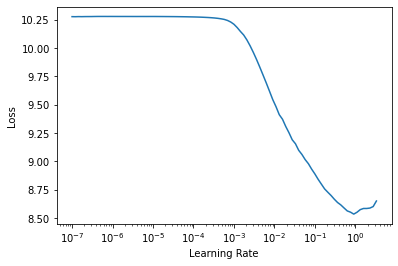

In [13]:
learn.lr_find()

In [15]:
learn.fit_one_cycle(6, 3e-2, moms=(0.8, 0.7, 0.8), div=10)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.264885,4.952564,0.240430,141.537430,02:38
1,5.129139,4.830200,0.243210,125.236031,02:39
2,5.025999,4.695138,0.254998,109.413956,02:38
3,4.856927,4.541927,0.266338,93.871552,02:39
4,4.713766,4.338759,0.279961,76.612434,02:38
5,4.609632,4.273129,0.285596,71.745773,02:39


In [0]:
learn.save("stage1")

In [0]:
learn.freeze_to(-2)

SuggestedLRs(lr_min=4.786300996784121e-05, lr_steep=9.12010818865383e-07)

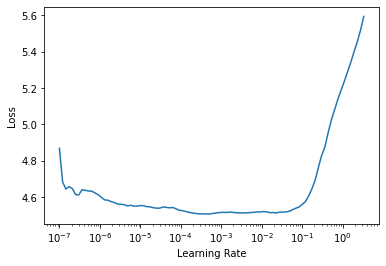

In [20]:
learn.lr_find()

In [21]:
learn.fit_one_cycle(8, slice(3e-5, 3e-3), moms=(0.8, 0.7, 0.8), div=10)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.577274,4.270771,0.285692,71.576805,02:39
1,4.519545,4.262570,0.286866,70.992195,02:38
2,4.547676,4.225792,0.290173,68.428703,02:39
3,4.471305,4.182848,0.292525,65.552277,02:38
4,4.458031,4.147266,0.297173,63.260834,02:39
5,4.374559,4.114178,0.299680,61.201897,02:38
6,4.340110,4.096126,0.302307,60.106987,02:38
7,4.286541,4.092118,0.302221,59.866543,02:38


In [0]:
learn.save("stage2")

In [0]:
learn.unfreeze()

SuggestedLRs(lr_min=2.7542287170945203e-07, lr_steep=4.786300905834651e-06)

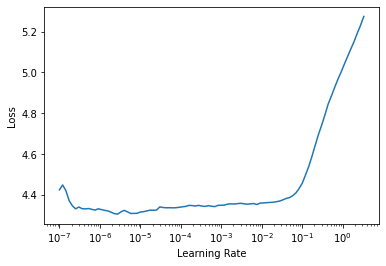

In [24]:
learn.lr_find()

In [25]:
learn.fit_one_cycle(10, slice(1e-6, 1e-4), moms=(0.8, 0.7, 0.8), div=10)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.350467,4.091331,0.302387,59.819431,02:38
1,4.341102,4.089506,0.302276,59.710369,02:39
2,4.321829,4.088938,0.302632,59.676468,02:39
3,4.337570,4.086801,0.302907,59.549065,02:39
4,4.336062,4.085463,0.302874,59.469467,02:39
5,4.327382,4.084330,0.303198,59.402130,02:39
6,4.327363,4.083515,0.303168,59.353741,02:39
7,4.335137,4.082997,0.303184,59.322987,02:38
8,4.344481,4.082734,0.303156,59.307373,02:39
9,4.320982,4.082703,0.303225,59.305565,02:39


In [0]:
learn.save("stage3")

# Credit

* https://dev.fast.ai/tutorial.wikitext